In [1]:
# Importing the Libraries
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import itertools
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout, BatchNormalization
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.optimizers import RMSprop, Adam
from ta.trend import MACD
from ta.momentum import RSIIndicator,StochasticOscillator
from ta.volatility import BollingerBands
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Importing the Dataset
df=pd.read_csv(r'portfolio_data.csv')
df.head()

,Date,AMZN,DPZ,BTC,NFLX
0,5/1/2013,248.229996,51.190983,106.250000,30.415714
1,5/2/2013,252.550003,51.987320,98.099998,30.641428
2,5/3/2013,258.049988,52.446388,112.900002,30.492857
3,5/6/2013,255.720001,53.205257,109.599998,30.098572
4,5/7/2013,257.730011,54.151505,113.199997,29.464285


In [3]:
# Checking for missing values
print(df.isnull().sum())

Date    0
AMZN    0
DPZ     0
BTC     0
NFLX    0
dtype: int64


In [4]:
# Converting Date column to Datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
# Checking Data Types
print(df.dtypes)

Date    datetime64[ns]
AMZN           float64
DPZ            float64
BTC            float64
NFLX           float64
dtype: object


In [6]:
# Setting Date Column as the index for Time Series Analysis
df.set_index('Date', inplace=True)

## Exploratory Data Analysis (EDA)

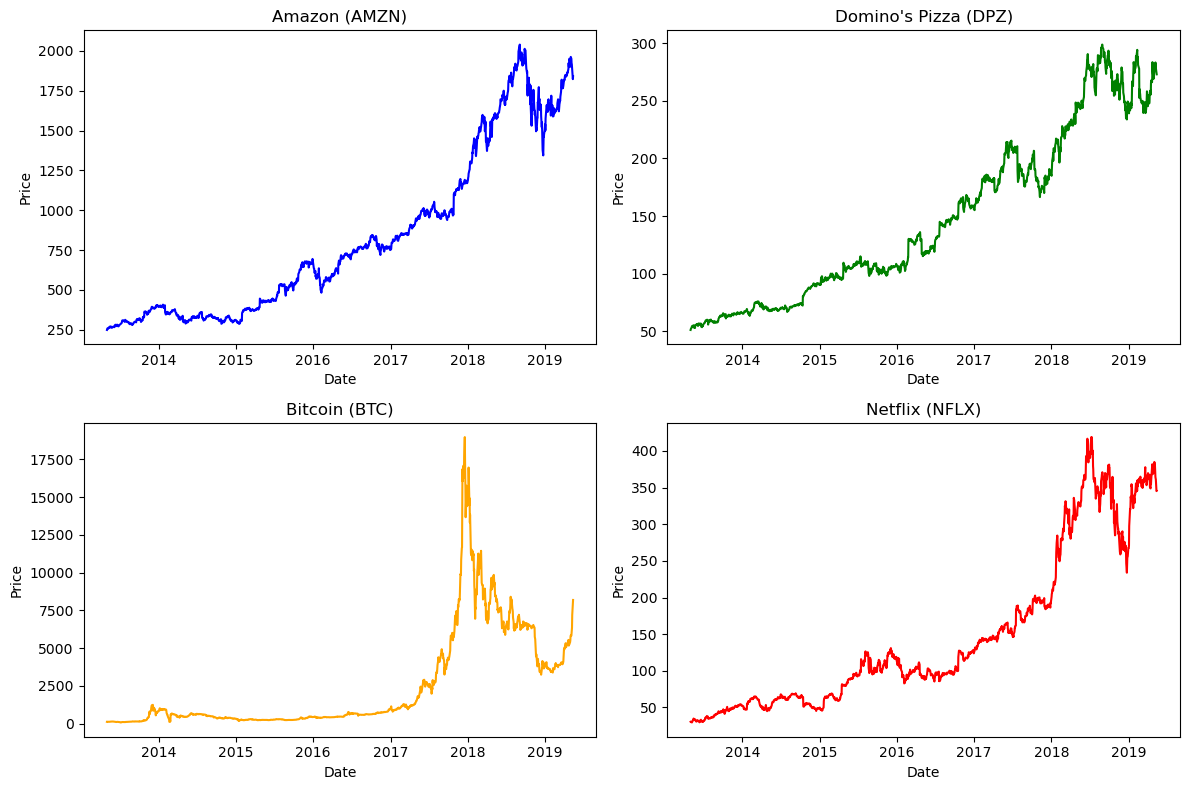

In [7]:
# Plotting each Stock's price over time
plt.figure(figsize=(12,8))

# Amazon (AMZN)
plt.subplot(2, 2, 1)
plt.plot(df.index, df['AMZN'], color='blue')
plt.title('Amazon (AMZN)')
plt.xlabel('Date')
plt.ylabel('Price')

# Domino's Pizza (DPZ)
plt.subplot(2, 2, 2)
plt.plot(df.index, df['DPZ'], color='green')
plt.title("Domino's Pizza (DPZ)")
plt.xlabel('Date')
plt.ylabel('Price')

# Bitcoin (BTC)
plt.subplot(2, 2, 3)
plt.plot(df.index, df['BTC'], color='orange')
plt.title('Bitcoin (BTC)')
plt.xlabel('Date')
plt.ylabel('Price')

# Netflix (NFLX)
plt.subplot(2, 2, 4)
plt.plot(df.index, df['NFLX'], color='red')
plt.title('Netflix (NFLX)')
plt.xlabel('Date')
plt.ylabel('Price')

plt.tight_layout()

# Show plot
plt.show()

## Correlation Analysis

Correlation Matrix:
          AMZN       DPZ       BTC      NFLX
AMZN  1.000000  0.972172  0.759802  0.980117
DPZ   0.972172  1.000000  0.708857  0.950453
BTC   0.759802  0.708857  1.000000  0.746428
NFLX  0.980117  0.950453  0.746428  1.000000


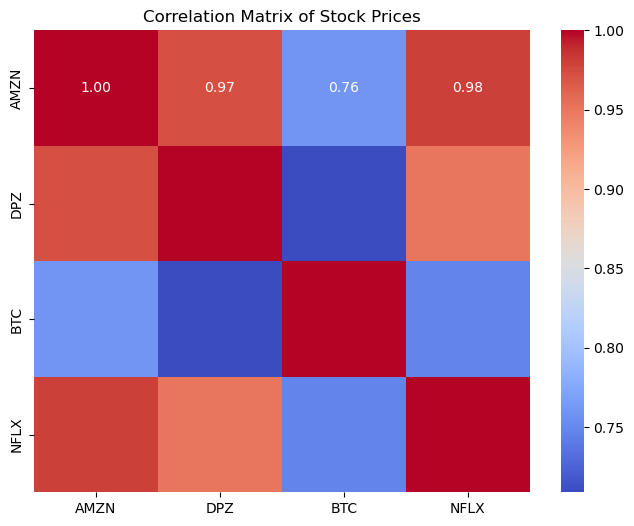

In [8]:
# Calculating correlation matrix
correlation_matrix = df[['AMZN', 'DPZ', 'BTC', 'NFLX']].corr()

print("Correlation Matrix:")
print(correlation_matrix)

# Visualize correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Stock Prices')
plt.show()

### The correlation matrix shows that there is a strong positive correlation between the stock prices of AMZN and NFLX and AMZN and DPZ

## Time Series Decomposition

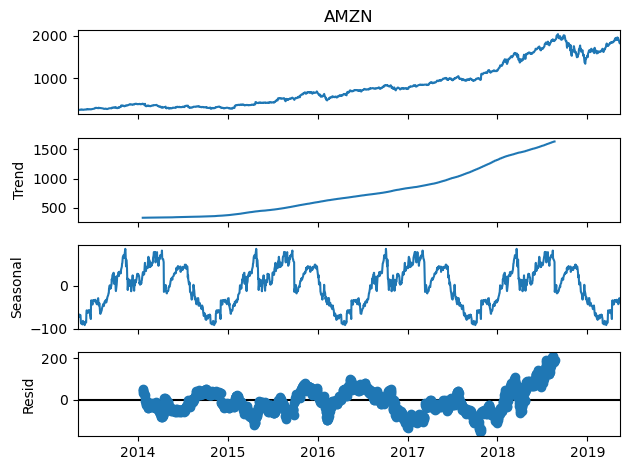

In [9]:
period = 365

# Performing time series decomposition
stock_price = df['AMZN']
decomposition = seasonal_decompose(stock_price, model='additive', period=period)

# Plotting the decomposition components
decomposition.plot()
plt.show()

* We see that the stock prices has a positive trend, there was a increase in prices in 2018

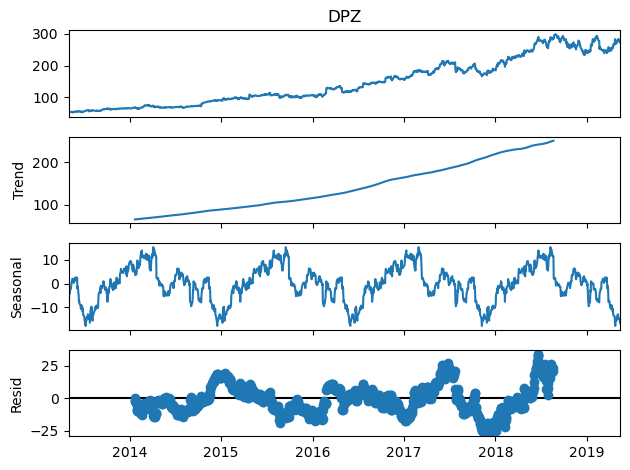

In [10]:
stock_price = df['DPZ']
decomposition = seasonal_decompose(stock_price, model='additive', period=period)

decomposition.plot()
plt.show()

* Here, we see, stock prices increases with a positive trend and was at peak in the first months of 2018

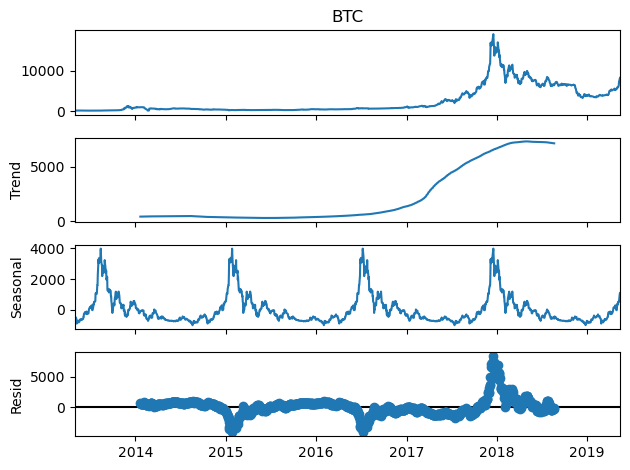

In [11]:
stock_price = df['BTC']
decomposition = seasonal_decompose(stock_price, model='additive', period=period)

decomposition.plot()
plt.show()

* Here, we see that the trend of stock prices did not show a increase till 2017. After that, it shows a gradual increase and was at peak in 2018

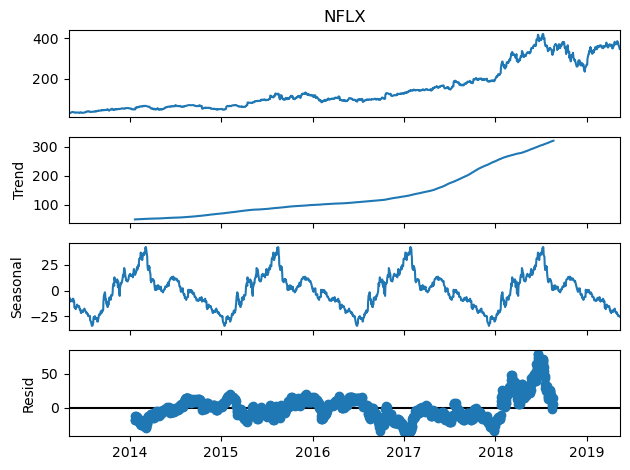

In [12]:
stock_price = df['NFLX']
decomposition = seasonal_decompose(stock_price, model='additive', period=period)

decomposition.plot()
plt.show()

* Here, we observe, a positive trend in stock prices, mainly after 2017.

## Rolling Statistics

In [13]:
# Calculate rolling statistics for each asset
window_sizes = [7, 30]  # Define the window sizes for rolling statistics

for asset in ['AMZN', 'DPZ', 'BTC', 'NFLX']:
    for window_size in window_sizes:
        # Calculate moving averages
        df[f'{asset}_MA_{window_size}'] = df[asset].rolling(window=window_size, min_periods=1).mean()
        # Calculate standard deviations
        df[f'{asset}_STD_{window_size}'] = df[asset].rolling(window=window_size, min_periods=1).std()

# Display the updated dataframe with additional features
print(df.head())

                  AMZN        DPZ         BTC       NFLX   AMZN_MA_7  \
Date                                                                   
2013-05-01  248.229996  51.190983  106.250000  30.415714  248.229996   
2013-05-02  252.550003  51.987320   98.099998  30.641428  250.389999   
2013-05-03  258.049988  52.446388  112.900002  30.492857  252.943329   
2013-05-06  255.720001  53.205257  109.599998  30.098572  253.637497   
2013-05-07  257.730011  54.151505  113.199997  29.464285  254.456000   

            AMZN_STD_7  AMZN_MA_30  AMZN_STD_30   DPZ_MA_7  DPZ_STD_7  \
Date                                                                    
2013-05-01         NaN  248.229996          NaN  51.190983        NaN   
2013-05-02    3.054706  250.389999     3.054706  51.589151   0.563095   
2013-05-03    4.921797  252.943329     4.921797  51.874897   0.635208   
2013-05-06    4.251690  253.637497     4.251690  52.207487   0.843479   
2013-05-07    4.111859  254.456000     4.111859  52.59629

## MACD

In [14]:
# Defining a function to calculate MACD
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data.ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return macd_line, signal_line, macd_histogram

# Calculating MACD for each asset
for asset in ['AMZN', 'DPZ', 'BTC', 'NFLX']:
    macd_line, signal_line, macd_histogram = calculate_macd(df[asset])
    df[f'{asset}_MACD'] = macd_line
    df[f'{asset}_Signal'] = signal_line
    df[f'{asset}_MACD_Histogram'] = macd_histogram

# Dropping rows with NaN values resulting from MACD calculations
df.dropna(inplace=True)

# Displaying the updated dataframe with MACD features
print(df.head())

                  AMZN        DPZ         BTC       NFLX   AMZN_MA_7  \
Date                                                                   
2013-05-02  252.550003  51.987320   98.099998  30.641428  250.389999   
2013-05-03  258.049988  52.446388  112.900002  30.492857  252.943329   
2013-05-06  255.720001  53.205257  109.599998  30.098572  253.637497   
2013-05-07  257.730011  54.151505  113.199997  29.464285  254.456000   
2013-05-08  258.679993  54.385727  112.800003  29.801428  255.159999   

            AMZN_STD_7  AMZN_MA_30  AMZN_STD_30   DPZ_MA_7  DPZ_STD_7  ...  \
Date                                                                   ...   
2013-05-02    3.054706  250.389999     3.054706  51.589151   0.563095  ...   
2013-05-03    4.921797  252.943329     4.921797  51.874897   0.635208  ...   
2013-05-06    4.251690  253.637497     4.251690  52.207487   0.843479  ...   
2013-05-07    4.111859  254.456000     4.111859  52.596291   1.135533  ...   
2013-05-08    4.061969  255

## Relative Strength Index (RSI)

In [15]:
# Defining a function to calculate RSI
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculating RSI for each asset
for asset in ['AMZN', 'DPZ', 'BTC', 'NFLX']:
    df[f'{asset}_RSI'] = calculate_rsi(df[asset])

# Dropping rows with NaN values resulting from RSI calculations
df.dropna(inplace=True)

# Displaying the updated dataframe with RSI features
print(df.head())

                  AMZN        DPZ         BTC       NFLX   AMZN_MA_7  \
Date                                                                   
2013-05-21  268.859985  53.355167  123.800003  33.869999  267.129996   
2013-05-22  262.959991  53.036613  126.300003  32.651428  266.908565   
2013-05-23  261.799988  55.472504  133.100006  32.311428  265.975708   
2013-05-24  261.739990  55.013439  131.990005  32.677143  265.287135   
2013-05-28  267.290009  55.894104  132.250000  30.598572  265.739995   

            AMZN_STD_7  AMZN_MA_30  AMZN_STD_30   DPZ_MA_7  DPZ_STD_7  ...  \
Date                                                                   ...   
2013-05-21    2.183463  261.643998     6.437481  53.949409   0.763975  ...   
2013-05-22    2.542520  261.726248     6.227893  53.729911   0.775554  ...   
2013-05-23    3.076037  261.730586     6.030158  53.758018   0.841662  ...   
2013-05-24    3.441245  261.731108     5.850113  53.902565   0.967889  ...   
2013-05-28    3.470512  262

## Stationarity testing

In [16]:
# For AMZN
stock_price = df['AMZN']

# Performing Augmented Dickey-Fuller test
result = adfuller(stock_price)

# Printing test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Printing critical values
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpreting the results
if result[1] < 0.05:
    print('Reject the null hypothesis (H0): Time series is stationary')
else:
    print('Fail to reject the null hypothesis (H0): Time series is non-stationary')


ADF Statistic: 0.5392670613937103
p-value: 0.9860189657510372
Critical Values:
   1%: -3.434773140073479
   5%: -2.8634935294626773
   10%: -2.5678100382791524
Fail to reject the null hypothesis (H0): Time series is non-stationary


In [17]:
# For DPZ
stock_price = df['DPZ']

# Performing Augmented Dickey-Fuller test
result = adfuller(stock_price)

# Printing test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Printing critical values
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpreting the results
if result[1] < 0.05:
    print('Reject the null hypothesis (H0): Time series is stationary')
else:
    print('Fail to reject the null hypothesis (H0): Time series is non-stationary')


ADF Statistic: -0.2916476588326043
p-value: 0.9266789717462814
Critical Values:
   1%: -3.4347170173134813
   5%: -2.8634687603081486
   10%: -2.5677968484444444
Fail to reject the null hypothesis (H0): Time series is non-stationary


In [18]:
# For BTC
stock_price = df['BTC']

# Performing Augmented Dickey-Fuller test
result = adfuller(stock_price)

# Printing test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Printing critical values
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpreting the results
if result[1] < 0.05:
    print('Reject the null hypothesis (H0): Time series is stationary')
else:
    print('Fail to reject the null hypothesis (H0): Time series is non-stationary')


ADF Statistic: -1.325747843297548
p-value: 0.6173118819488344
Critical Values:
   1%: -3.4347641828771405
   5%: -2.863489576334964
   10%: -2.5678079331921446
Fail to reject the null hypothesis (H0): Time series is non-stationary


In [19]:
# For NFLX
stock_price = df['NFLX']

# Performing Augmented Dickey-Fuller test
result = adfuller(stock_price)

# Printing test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Printing critical values
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpreting the results
if result[1] < 0.05:
    print('Reject the null hypothesis (H0): Time series is stationary')
else:
    print('Fail to reject the null hypothesis (H0): Time series is non-stationary')


ADF Statistic: -0.20871234196034022
p-value: 0.9374751302669961
Critical Values:
   1%: -3.4347671645756304
   5%: -2.86349089226533
   10%: -2.5678086339403325
Fail to reject the null hypothesis (H0): Time series is non-stationary


Since, Augmented Dickey-Fuller (ADF) test indicates that all four stock price series are non-stationary

In [20]:
# Performing first-order differencing on the stock prices
diff_stock_price = df.diff().dropna()

for col in diff_stock_price.columns:
    result = adfuller(diff_stock_price[col])
    print(f'Stock: {col}')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] < 0.05:
        print('Reject the null hypothesis (H0): Time series is stationary')
    else:
        print('Fail to reject the null hypothesis (H0): Time series is non-stationary')
    print()


Stock: AMZN
ADF Statistic: -7.822106551600466
p-value: 6.627915374124375e-12
Critical Values:
   1%: -3.434773140073479
   5%: -2.8634935294626773
   10%: -2.5678100382791524
Reject the null hypothesis (H0): Time series is stationary

Stock: DPZ
ADF Statistic: -17.534330257812282
p-value: 4.220980986259948e-30
Critical Values:
   1%: -3.4347170173134813
   5%: -2.8634687603081486
   10%: -2.5677968484444444
Reject the null hypothesis (H0): Time series is stationary

Stock: BTC
ADF Statistic: -8.641019303549909
p-value: 5.4258877273613175e-14
Critical Values:
   1%: -3.4347641828771405
   5%: -2.863489576334964
   10%: -2.5678079331921446
Reject the null hypothesis (H0): Time series is stationary

Stock: NFLX
ADF Statistic: -8.06550447689566
p-value: 1.6003678644917606e-12
Critical Values:
   1%: -3.4347671645756304
   5%: -2.86349089226533
   10%: -2.5678086339403325
Reject the null hypothesis (H0): Time series is stationary

Stock: AMZN_MA_7
ADF Statistic: -6.529528819862293
p-value: 

## Modeling & Model Evaluation

In [21]:
# Assuming df is your DataFrame with all the required columns
# Creating lag features
def create_lag_features(df, lag=5):
    for col in df.columns:
        for l in range(1, lag + 1):
            df[f'{col}_lag_{l}'] = df[col].shift(l)
    return df

# Creating window statistics
def create_window_stats(df, window=5):
    for col in df.columns:
        df[f'{col}_mean_{window}'] = df[col].rolling(window=window).mean()
        df[f'{col}_std_{window}'] = df[col].rolling(window=window).std()
    return df

# Applying feature engineering
df = create_lag_features(df)
df = create_window_stats(df)

# Dropping rows with NaN values created by shifting
df.dropna(inplace=True)

# Preparing your data (example with features and target variable)
features = df.drop(columns=['AMZN', 'DPZ', 'BTC', 'NFLX'])
target = df[['AMZN', 'DPZ', 'BTC', 'NFLX']]

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Normalizing the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing lists to store predictions
base_model_predictions = []

# Defining the base LSTM model creation function
def create_base_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=200, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=100))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Training base LSTM models on different subsets of data
for i in range(4):  # Assuming 4 subsets for AMZN, DPZ, BTC, and NFLX
    # Create base model
    base_model = create_base_lstm_model((1, 1))
    
    # Fitting the base model on the subset of training data
    X_train_subset = X_train_scaled[:, i].reshape(-1, 1, 1)
    y_subset = y_train.iloc[:, i].values.reshape(-1, 1)
    base_model.fit(X_train_subset, y_subset, epochs=100, batch_size=32, verbose=0)
    
    # Making predictions on validation data
    X_val_subset = X_test_scaled[:, i].reshape(-1, 1, 1)
    subset_predictions = base_model.predict(X_val_subset)
    base_model_predictions.append(subset_predictions)

# Concatenating base model predictions to form the meta-model input
X_meta_train = np.concatenate(base_model_predictions, axis=1)

# Training RandomForest meta-model
meta_model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
meta_model_rf.fit(X_meta_train, y_test.mean(axis=1))

# Making predictions with the meta-model
meta_predictions_rf = meta_model_rf.predict(X_meta_train)

# Evaluating the meta-model
meta_rmse_rf = mean_squared_error(y_test.mean(axis=1), meta_predictions_rf, squared=False)
meta_mae_rf = mean_absolute_error(y_test.mean(axis=1), meta_predictions_rf)
print("Meta-model RF RMSE:", meta_rmse_rf)
print("Meta-model RF MAE:", meta_mae_rf)


C:\Users\princ\AppData\Local\Temp\ipykernel_22168\3365336426.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{l}'] = df[col].shift(l)
C:\Users\princ\AppData\Local\Temp\ipykernel_22168\3365336426.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{l}'] = df[col].shift(l)
C:\Users\princ\AppData\Local\Temp\ipykernel_22168\3365336426.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step
Meta-model RF RMSE: 94.23384487011684
Meta-model RF MAE: 42.906157200450046


C:\Users\princ\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


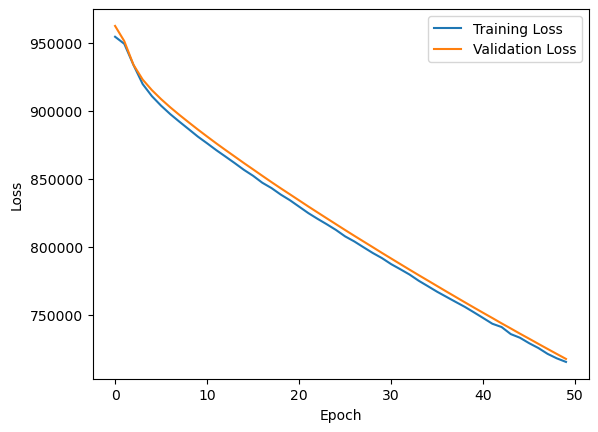

In [22]:
i = 0  
base_model = create_base_lstm_model((1, 1))
X_train_subset = X_train_scaled[:, i].reshape(-1, 1, 1)
y_subset = y_train.iloc[:, i].values.reshape(-1, 1)
X_val_subset = X_test_scaled[:, i].reshape(-1, 1, 1)
y_val = y_test.iloc[:, i].values.reshape(-1, 1)

# Capturing history object
history = base_model.fit(X_train_subset, y_subset, epochs=50, batch_size=32, validation_data=(X_val_subset, y_val), verbose=0)

# Plotting training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Forecasting

In [23]:
# Training base LSTM models on different subsets of data and store them
base_models = []
for i in range(4):  # Assuming 4 subsets for AMZN, DPZ, BTC, and NFLX
    # Creating base model
    base_model = create_base_lstm_model((1, 1))
    
    # Fitting the base model on the subset of training data
    X_train_subset = X_train_scaled[:, i].reshape(-1, 1, 1)
    y_subset = y_train.iloc[:, i].values.reshape(-1, 1)
    base_model.fit(X_train_subset, y_subset, epochs=100, batch_size=32, verbose=0)
    
    # Storing the trained base model
    base_models.append(base_model)

# Initializing lists to store base model forecasts
base_model_forecasts = []

# Using base LSTM models to forecast each subset of data
for i in range(4):  # Assuming 4 subsets for AMZN, DPZ, BTC, and NFLX
    # Use the corresponding base LSTM model to make forecasts
    subset_model = base_models[i]
    
    # Preparing input data for forecasting (reshape as needed)
    X_forecast_subset = X_test_scaled[:, i].reshape(-1, 1, 1)
    
    # Using the corresponding base LSTM model to make forecasts
    subset_forecasts = subset_model.predict(X_forecast_subset)
    base_model_forecasts.append(subset_forecasts)

# Concatenating base model forecasts to form the input for the meta-model
X_meta_forecast = np.concatenate(base_model_forecasts, axis=1)

# Using the trained meta-model (RandomForestRegressor) to make the final forecasts
meta_forecasts = meta_model_rf.predict(X_meta_forecast)

# Printing or use the meta_forecasts for further analysis
print("Meta-model Forecasts:", meta_forecasts)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
Meta-model Forecasts: [1398.32444422 1573.94619625 1661.86398665 1641.07740612 1395.04891874
 1396.22004456 1405.46737219 1395.72060268 1397.3734997  1394.87136854
 1372.64107469 1565.80531419 1528.50782589 1623.17573351 1394.24376453
 1394.11885063 1395.86758935 1449.76184314 1394.32601185 1394.32601185
 1442.42313124 1394.35526302 1399.88012262 1550.65023735 1397.3734997
 1434.18958537 1434.60269951 1511.74567114 1607.7618129  1416.89260169
 1364.3857106  1361.28472534 1395.28661119 1579.93378017 1403.76800883
 1516.85711989 1394.11885063 1399.64243017 1505.99822467 1395.98392823
 1353.04229695 1340.57592125 1394.11885063 1427.12142313 1578.17262047
 1343.64923729 1359.68085392 1394.32601185 1411.3647961  1587.80761937
 1417.83886242 1357.99136262 1397.65149274 1395.28661119 1394.24376453
 1678.22737114 1394.24376453 1414.

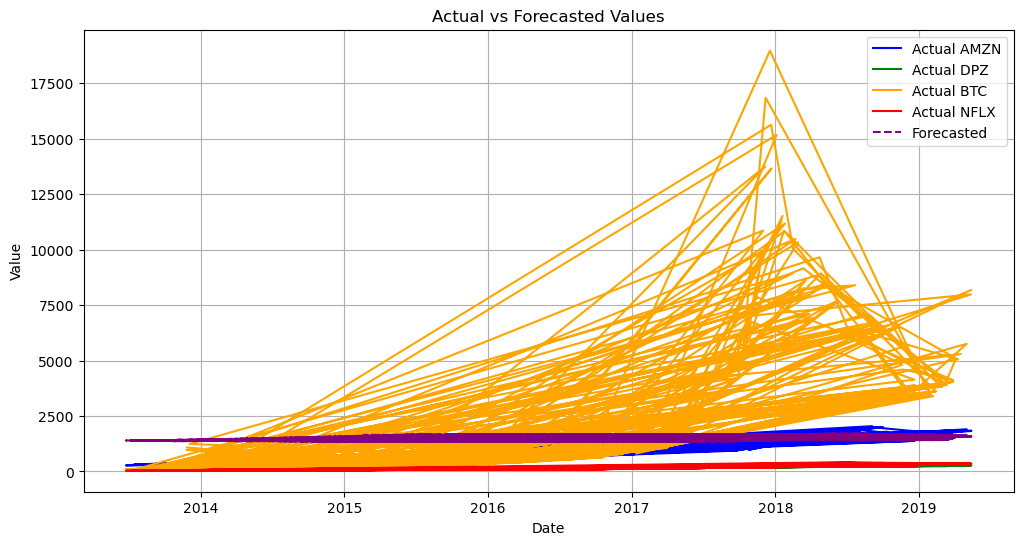

In [24]:
# Plotting the forecasted values for each stock
plt.figure(figsize=(12, 6))

# Plotting actual values
plt.plot(y_test.index, y_test['AMZN'], label='Actual AMZN', color='blue')
plt.plot(y_test.index, y_test['DPZ'], label='Actual DPZ', color='green')
plt.plot(y_test.index, y_test['BTC'], label='Actual BTC', color='orange')
plt.plot(y_test.index, y_test['NFLX'], label='Actual NFLX', color='red')

# Plotting forecasted values
plt.plot(y_test.index, meta_forecasts, label='Forecasted', linestyle='dashed', color='purple')

plt.title('Actual vs Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
